#Wine Type Prediction (Multi-class Classification)

This data set is taken from the UCI repository (link [here](https://archive.ics.uci.edu/ml/datasets/wine)). I have done some basic pre-processing of the data in Excel, like adding headers based on the dataset description and converting the dataset to the CSV format. As usual, I've ingested this data from my personal Drive, and this project's GitHub repository has the pre-processed dataset (in CSV format).

###Dataset Information:

**Winelab.csv**: To quote the UCI dataset description:


> *These data are the results of a chemical analysis of
      wines grown in the same region in Italy but derived from three
      different cultivars.
      The analysis determined the quantities of 13 constituents
      found in each of the three types of wines. *
      
Basically, there are 3 different types of wines and their attributes are their chemical compositions (Alcohol, Malic Acid, Ash etc.). Fortunately, this is a dataset with continuous quantitative features only. This makes our life a lot easier!



## Install and import necessary libraries

In [0]:
!pip3 install -U -q PyDrive #Only if you are loading your data from Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

## Authorize Google Drive (if your data is stored in Drive)

In [0]:
%%capture
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Data Ingestion

I have saved the file in my personal drive storage and read it from there into a pandas data frame. Please modify the following cells to read the CSV files into a Pandas dataframe as per your storage location.

In [0]:
%%capture
downloaded = drive.CreateFile({'id':'1Tghlhn7nTZv_WOV7typp9fFZil4TjZ_9'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Winelab.csv')  
winedata = pd.read_csv('Winelab.csv') 

Let's take a sneak peek at the data

In [5]:
winedata.head()

,Wine_Class,Alcohol,Malic_acid,Ash,Alkalinity_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
winedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Wine_Class              178 non-null int64
Alcohol                 178 non-null float64
Malic_acid              178 non-null float64
Ash                     178 non-null float64
Alkalinity_ash          178 non-null float64
Magnesium               178 non-null int64
Total_phenols           178 non-null float64
Flavanoids              178 non-null float64
Nonflavanoid_phenols    178 non-null float64
Proanthocyanins         178 non-null float64
Color_intensity         178 non-null float64
Hue                     178 non-null float64
OD280_OD315             178 non-null float64
Proline                 178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


As we can see, we have 13 attributes for each wine with one class label (*Wine_Class*).

##Data Preparation

To prepare the data for analysis, we need to convert our Wine Class feature to a categorical one and scale the features, to prepare for dimensionality reduction using Principal Component Analysis (PCA).

In [0]:
winedata['Wine_Class']=winedata['Wine_Class'].astype('category')

In the previous section, we noticed that all 13 attributes of each wine are measured on completely different scales. To run PCA, and most machine learning algorithms, we need to focus on keeping the data around the same scale, so that no one feature can overpower the others with pure magnitude.

In [0]:
scaler = StandardScaler()
winedatapc=winedata.copy()
scaler.fit(winedatapc.iloc[:,1:])
winedatapc.iloc[:,1:]=scaler.transform(winedatapc.iloc[:,1:])

Now, one can see that all data has been scaled i.e. each feature (except the class label, of course) has been centered and scaled to unit variance (Z scores).

In [9]:
winedatapc.head()

,Wine_Class,Alcohol,Malic_acid,Ash,Alkalinity_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
0,1,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,1,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,1,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


##Dimension Reduction (using PCA)

We are going to generate all possible Principal Components for our dataset (13), plot them to see how well segregated the classes are, and decide on the number of components we are going to use for our prediction algorithm.

The following lines of code generate the Principal Component scores of all the observations, for all 13 principal components (PC0 through PC12).

In [10]:
pca = PCA(n_components=13,random_state=0)
PCAscores=pd.DataFrame(pca.fit_transform(winedatapc.iloc[:,1:]))
PCAscores=PCAscores.rename('PC{}'.format, axis='columns')
PCAscores['Wine_Class']=winedatapc.Wine_Class
PCAscores.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,Wine_Class
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,0.596427,0.065139,0.641443,1.020956,-0.451563,0.540810,-0.066239,1
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,0.053776,1.024416,-0.308847,0.159701,-0.142657,0.388238,0.003637,1
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,0.424205,-0.344216,-1.177834,0.113361,-0.286673,0.000584,0.021717,1
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,-0.383337,0.643593,0.052544,0.239413,0.759584,-0.242020,-0.369484,1
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,0.444074,0.416700,0.326819,-0.078366,-0.525945,-0.216664,-0.079364,1


To see what these Principal Components mean, we create a loadings dataframe for each attribute of the dataframe (columns), for each Principal Component (index)

In [11]:
load=pd.DataFrame(pca.components_,columns=winedatapc.iloc[:,1:].columns)
load=load.rename('PC{}'.format, axis='index')
load

,Alcohol,Malic_acid,Ash,Alkalinity_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280_OD315,Proline
PC0,0.144329,-0.245188,-0.002051,-0.239320,0.141992,0.394661,0.422934,-0.298533,0.313429,-0.088617,0.296715,0.376167,0.286752
PC1,-0.483652,-0.224931,-0.316069,0.010591,-0.299634,-0.065040,0.003360,-0.028779,-0.039302,-0.529996,0.279235,0.164496,-0.364903
PC2,-0.207383,0.089013,0.626224,0.612080,0.130757,0.146179,0.150682,0.170368,0.149454,-0.137306,0.085222,0.166005,-0.126746
PC3,-0.017856,0.536890,-0.214176,0.060859,-0.351797,0.198068,0.152295,-0.203301,0.399057,0.065926,-0.427771,0.184121,-0.232071
PC4,-0.265664,0.035214,-0.143025,0.066103,0.727049,-0.149318,-0.109026,-0.500703,0.136860,-0.076437,-0.173615,-0.101161,-0.157869
PC5,-0.213539,-0.536814,-0.154475,0.100825,-0.038144,0.084122,0.018920,0.258594,0.533795,0.418644,-0.105983,-0.265851,-0.119726
PC6,-0.056396,0.420524,-0.149171,-0.286969,0.322883,-0.027925,-0.060685,0.595447,0.372139,-0.227712,0.232076,-0.044764,0.076805
PC7,-0.396139,-0.065827,0.170260,-0.427970,0.156361,0.405934,0.187245,0.233285,-0.368227,0.033797,-0.436624,0.078108,-0.120023
PC8,0.508619,-0.075283,-0.307694,0.200449,0.271403,0.286035,0.049578,0.195501,-0.209145,0.056218,0.085828,0.137227,-0.575786
PC9,0.211605,-0.309080,-0.027125,0.052799,0.067870,-0.320131,-0.163151,0.215535,0.134184,-0.290775,-0.522399,0.523706,0.162116


To interpret the above table, we take an example of the first row (PC0 i.e. the first Principal Component). The highest dependence of this PC is on *Flavanoids* and the dependence is positive. This implies that the higher the amount of Flavanoids in this wine, the higher the score of the first principal component. The highest negative dependence is on *Nonflavanoid_phenols*, which implies the higher the *Nonflavanoid_phenols* attribute for a wine, the lower the PC score will be. This can be extended to all other PCs.

We now visualize all the wines (observations) using the first 2 Principal Components to see if the class distributions are well separated.

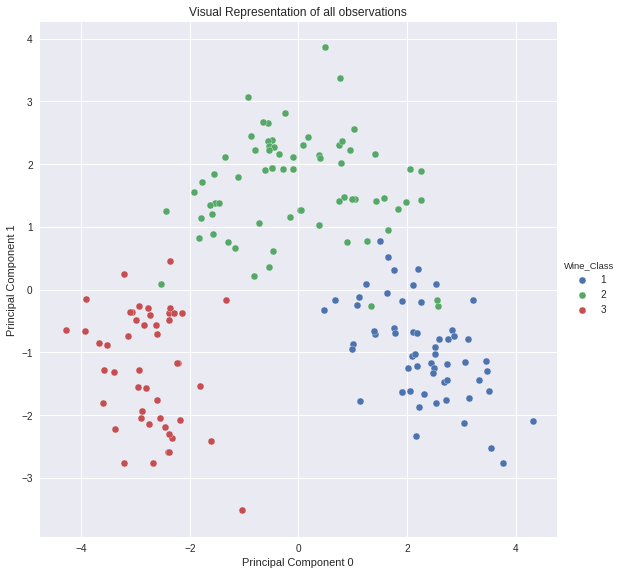

In [12]:
PC=sns.pairplot(x_vars=['PC0'], y_vars=['PC1'], data=PCAscores, hue="Wine_Class", size=8)
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.title('Visual Representation of all observations')
plt.show()

We can see that the 3 categories of wine, are pretty well segregated. This is good, as we have distinct features for each type of wine. This will improve the accuracy of our prediction algorithm.

The next task is to use these Principal Components to reduce the dimension of the problem. To see how many Principal Components we need, we are going to try 2 approaches:


1) Scree Plot 

2) Percentage of Variance Explained

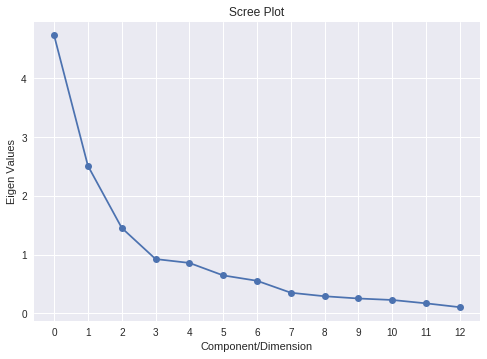

In [13]:
scree=plt.plot(pca.explained_variance_,'o-')
plt.title('Scree Plot')
plt.ylabel('Eigen Values')
plt.xlabel('Component/Dimension')
plt.xticks(range(0,13))
plt.show()

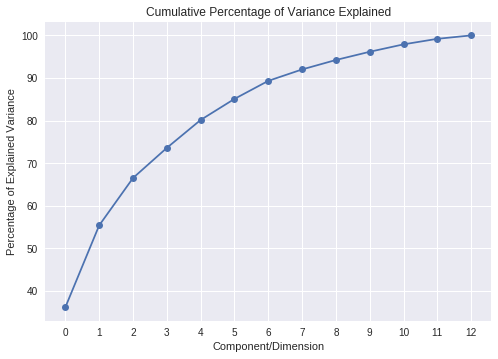

In [14]:
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
cumsum=plt.plot(var1,'o-')
plt.xlabel('Component/Dimension')
plt.ylabel('Percentage of Explained Variance')
plt.title('Cumulative Percentage of Variance Explained')
plt.xticks(range(0,13))
plt.show()

According to Kaiser's Rule, we should select the number of components that have eigen values greater than 1, and according to the variance rule, we should select the number of components that explain 95% of the variance in the data.

From Kaiser's Rule, we should select approximately 3 components (scree plot), and from the Variance Rule, we should select approximately 8 components. For this case, I'm going to be leaning towards the Variance Rule, but not exactly. I'm going to select the number of components that explain approximately 80% of the variation of the data.


**This implies that I'm going to choose 5 components.**

The code below selects only the first 5 principal component scores.

In [0]:
X=PCAscores.iloc[:,:5].copy()
X=X.values
y=PCAscores.Wine_Class.astype(np.int64).values

##Prediction

###Split Data: Training and Testing

**We split the data to use 70% of it for training our machine learning models, and the remaining 30% for testing.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

###Class distribution

**A large part of how we decide which Machine Learning model to choose will depend on the class distribution. **

In [17]:
unique, counts = np.unique(y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 1 59]
 [ 2 71]
 [ 3 48]]


**So we have a noticeably uneven class distribution. This skew can introduce a bias in our model, and hence we need to be careful with our scoring method.**

**We chose the F1 micro score as a measure of model performance as we have an uneven class distribution (we have more ones than zeros in our class labels). For a more detailed explanation (and formulae), please see [this link.](https://blogs.msdn.microsoft.com/andreasderuiter/2015/02/09/performance-measures-in-azure-ml-accuracy-precision-recall-and-f1-score/)**

###Method 1: K-Nearest Neighbours (KNN)

####Hyperparameter Tuning

**In the case of KNN, we tune the type of distance metric used and the number of nearest neigbours considered in classification.**

In [0]:
def knn_param_selection(X, y, nfolds):
  n_neighborss = [3,4,5,6,7,8,9,10,11,12,13,14,15]
  metrics=['minkowski','euclidean','manhattan']
  param_grid = {'n_neighbors': n_neighborss,'metric':metrics}
  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=nfolds,scoring='f1_micro')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [19]:
knn_param_selection(X_train, y_train, 10)

{'metric': 'minkowski', 'n_neighbors': 5}

**The grid search reveals that we should use the *minkowski* distance metric and the *5 nearest neighbours* to maximize the F1 (micro) score. Since we have a class imbalance, we have used the F1 Micro score.**

####Model Fitting and Analysis

In [20]:
knnclass = KNeighborsClassifier(n_neighbors=5,metric='minkowski')  
knnclass.fit(X_train, y_train)  
y_pred = knnclass.predict(X_test) 
print('K-Nearest Neighbors predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

K-Nearest Neighbors predicts the correct class label with a 98.15 % accuracy.


In [21]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = KNeighborsClassifier(n_neighbors=5,metric='minkowski')
scoring = 'f1_micro'
results = cross_val_score(modelCV, X, y, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 micro score: %.3f" % (results.mean()))

10-fold average cross validation average F1 micro score: 0.950


###Method 2: Logistic Regression


####Hyperparameter Tuning

**We tune the regularization parameter (*C*) for logistic regression using a 10 fold cross validated Grid Search, using our training set. Notice, that we have set the grid search to maximize the F1 micro score for our model. **

In [0]:
def lgr_param_selection(X, y, nfolds):
  Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3]
  param_grid = {'C': Cs}
  grid_search = GridSearchCV(LogisticRegression(max_iter=1000,solver='sag',penalty='l2',random_state=0), param_grid, cv=nfolds,scoring='f1_micro')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [23]:
lgr_param_selection(X_train, y_train, 10)

{'C': 0.5}

**The Grid Search has yielded a regularization parameter (C) of 0.5. Note that we have used the L2 norm penalty, as L1/Elastic Net would perform automatic feature selection for us, which we have already done in the previous section.**

**We now apply this parameter to create a logistic regression model for analysis, and then run a 10 fold cross validation to check if we have a good model that is not overfitted.**

####Model Fitting and Analysis

In [24]:
logreg = LogisticRegression(max_iter=1000,solver='sag',penalty='l2',C=0.5,random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Logistic Regression predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

Logistic Regression predicts the correct class label with a 100.0 % accuracy.


In [25]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = LogisticRegression(max_iter=1000,solver='sag',penalty='l2',C=0.5,random_state=0)
scoring = 'f1_micro'
results = cross_val_score(modelCV, X, y, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 micro score: %.3f" % (results.mean()))

10-fold average cross validation average F1 micro score: 0.933


###Method 3: Support Vector Classifier with Linear Kernel

####Hyperparameter Tuning

In [0]:
def linsvc_param_selection(X, y, nfolds):
  Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2,2.5,3]
  param_grid = {'C': Cs}
  grid_search = GridSearchCV(LinearSVC(random_state=0), param_grid, cv=nfolds,scoring='f1_micro')
  grid_search.fit(X, y)
  grid_search.best_params_
  return grid_search.best_params_

In [27]:
linsvc_param_selection(X_train, y_train, 10)

{'C': 0.1}

####Model Fitting and Analysis

In [28]:
clf = LinearSVC(C=0.1,random_state=0)
linsvc = CalibratedClassifierCV(clf) 
linsvc.fit(X_train, y_train)
y_pred=linsvc.predict(X_test) 
print('Linear SVC predicts the correct class label with a',str(round(accuracy_score(y_test, y_pred)*100,2)),'% accuracy.')

Linear SVC predicts the correct class label with a 100.0 % accuracy.


In [29]:
kfold=KFold(n_splits=10, random_state=0)
modelCV = CalibratedClassifierCV(LinearSVC(C=0.1,random_state=0)) 
scoring = 'f1_micro'
results = cross_val_score(modelCV, X, y, cv=kfold,scoring=scoring)
print("10-fold average cross validation average F1 micro score: %.3f" % (results.mean()))

10-fold average cross validation average F1 micro score: 0.944


###Summary

We have seen a multi-class dataset, and have more than halved the number of features using Principal Component Analysis. As we can see, PCA is an extremely powerful tool for feature selection (or feature engineering, in a way!), and one major advantage it has is that it produces orthogonal, independent components. We used the Principal Components in 3 machine learning algorithms, to predict our class labels. Since we had a class imbalance, we used the F1 Micro score as our primary measure of effectiveness. The average scores of a 10 fold cross validation set (on the whole dataset) for each algorithm are tabulated below:



| Classifier | F1 Micro (10 fold CV) |
| --- | --- |
| K-Nearest Neighbours | 0.950
| Logistic Regression | 0.933
| Linear SVC | 0.944



It can be seen that the highest score is when we used the K-Nearest Neighbours algorithm, while the worst (not bad by any measure) was Logistic Regression. The power of simplicity really shines in this dataset. KNN is one of the simplest classifiers and yet was able to outperform far more complex classifiers. This can be attributed to the fact that our classes are very well segregated (see wine class scatter plot), and while the other two algorithms were able to predict the classes with 100% accuracy, they generalize worse, over the whole dataset. This is why KNN comes out on top. Simple, elegant and fast!